In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input, Dropout
from keras.models import Model

import omnifold8a as of

import tensorflow as tf


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.13.1





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]



#--- nominal
resolution = [ 0.5  ]

#--- poor
#resolution = [ 1.0  ]






train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
#-- about 10 seconds
#ngen_train = 10000
#ngen_true =   1000              

#-- about 10 seconds
#ngen_train = 20000
#ngen_true =   2000 
                
#-- about 62 seconds
#ngen_train = 100000
#ngen_true =    1000       


#-- about 37  (29 in of8a)  seconds
#ngen_train = 100000
#ngen_true =   10000

#-- about 47  (38 in of8a)  seconds
#ngen_train = 1000000
#ngen_true =   100000

#-- about 1   (56 seconds) minute
ngen_train = 2000000
ngen_true =   200000

#-- about 1:50  (1:48 in of8a)
#ngen_train = 4000000
#ngen_true =   400000

#-- about 5 min
#ngen_train = 10000000
#ngen_true =   1000000







of_niter = 5

#learning_rate_setval = 0.0005
#epochs_setval = 40

#learning_rate_setval = 0.0001
#epochs_setval = 10

#learning_rate_setval = 0.00002
#epochs_setval = 40

#learning_rate_setval = 0.0005
#epochs_setval = 10

#learning_rate_setval = 0.0010
#epochs_setval = 10

#learning_rate_setval = 0.0008
#epochs_setval = 10

#learning_rate_setval = 0.0005
#epochs_setval = 20

#learning_rate_setval = 0.0008
#epochs_setval = 20

learning_rate_setval = 0.0002
epochs_setval = 20




#dropout_setval = 0.0


#dropout_setval = 0.02

dropout_setval = 0.10

#dropout_setval = 0.30

#dropout_setval = 0.20

#dropout_setval = 0.05


batch_size_setval = int( ngen_true )



output_dir = 'toy-study8a-1d-1a'

save_step2_model = True





 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()



 Output directory already exists:  toy-study8a-1d-1a


In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )


true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights


In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : toy-study8a-1d-1a/config.txt

2024-07-05 15:36:11.687051

ngen_train 2000000
ngen_true  200000
of_niter   5
ndim       1
learning_rate_setval  0.000200
epochs_setval  20
batch_size_setval  200000


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.5]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

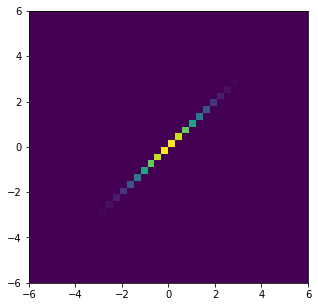

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

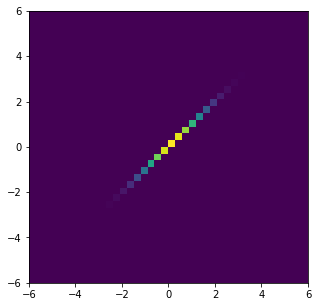

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

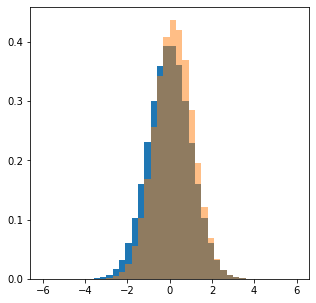

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [19]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[ 0.59753743]
 [ 0.22643034]
 [ 0.38817969]
 ...
 [ 0.92250046]
 [-0.94452043]
 [ 0.74032903]]


In [20]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[ 0.39753743]
 [ 0.02643034]
 [ 0.18817969]
 ...
 [ 0.72250046]
 [-1.14452043]
 [ 0.54032903]]


In [21]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [22]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [23]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [24]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [25]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [26]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [27]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [28]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [29]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.47194613 0.5499102  0.52324437 ... 0.36866441 0.36116355 0.42895276]


In [30]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.56861169 0.62660706 0.61332308 ... 0.45419397 0.27926298 0.52349707]


In [31]:
pdf_ratio = pdf_true / pdf_train

In [32]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [33]:
calc_weight = pdf_ratio

In [34]:
calc_weight_scaled = sample_sf * pdf_ratio

## Set up NN model for OmniFold

In [35]:

import tensorflow.keras.backend as K


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [36]:


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_4)

#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(200, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)

#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(150, activation='relu')(inputs)
#hidden_layer_2 = Dense(150, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(10, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(5, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(5, activation='relu')(inputs)
#hidden_layer_2 = Dense(10, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(30, activation='relu')(inputs)
#hidden_layer_2 = Dense(40, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(20, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)



#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#drop1 = Dropout(dropout_setval)(hidden_layer_1)
#hidden_layer_2 = Dense(50, activation='relu')(drop1)
#drop2 = Dropout(dropout_setval)(hidden_layer_2)
#hidden_layer_3 = Dense(50, activation='relu')(drop2)
#drop3 = Dropout(dropout_setval)(hidden_layer_3)
#outputs = Dense(1, activation='sigmoid')(drop3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(40, activation='relu')(inputs)
#drop1 = Dropout(dropout_setval)(hidden_layer_1)
#hidden_layer_2 = Dense(40, activation='relu')(drop1)
#drop2 = Dropout(dropout_setval)(hidden_layer_2)
#hidden_layer_3 = Dense(40, activation='relu')(drop2)
#drop3 = Dropout(dropout_setval)(hidden_layer_3)
#outputs = Dense(1, activation='sigmoid')(drop3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(30, activation='relu')(inputs)
#drop1 = Dropout(dropout_setval)(hidden_layer_1)
#hidden_layer_2 = Dense(40, activation='relu')(drop1)
#drop2 = Dropout(dropout_setval)(hidden_layer_2)
#hidden_layer_3 = Dense(30, activation='relu')(drop2)
#drop3 = Dropout(dropout_setval)(hidden_layer_3)
#outputs = Dense(1, activation='sigmoid')(drop3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#drop1 = Dropout(dropout_setval)(hidden_layer_1)
#hidden_layer_2 = Dense(30, activation='relu')(drop1)
#drop2 = Dropout(dropout_setval)(hidden_layer_2)
#hidden_layer_3 = Dense(10, activation='relu')(drop2)
#drop3 = Dropout(dropout_setval)(hidden_layer_3)
#outputs = Dense(1, activation='sigmoid')(drop3)

inputs = Input((ndim, ))
hidden_layer_1 = Dense(80, activation='relu')(inputs)
drop1 = Dropout(dropout_setval)(hidden_layer_1)
hidden_layer_2 = Dense(80, activation='relu')(drop1)
drop2 = Dropout(dropout_setval)(hidden_layer_2)
hidden_layer_3 = Dense(80, activation='relu')(drop2)
drop3 = Dropout(dropout_setval)(hidden_layer_3)
outputs = Dense(1, activation='sigmoid')(drop3)




model_step1 = Model(inputs=inputs, outputs=outputs)
model_step2 = Model(inputs=inputs, outputs=outputs)

opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

model_step1.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step1,
                      metrics=['accuracy'])

model_step2.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step2,
                      metrics=['accuracy'])


print('\n\n  Model for step1:')
model_step1.summary()

print('\n\n  Model for step2:')
model_step2.summary()




  Model for step1:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 80)                160       
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 dropout_2 (Dropout)         (None, 80) 

## Package the training data for OmniFold

In [37]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [38]:
%%time


#verbose = True
verbose = False






of_return_dict = of.omnifold8a( 
    train_both, true_det_pts, of_niter, model_step1, model_step2, verbose, 
    batch_size_setval, epochs_setval,
    save_step2_model, output_dir
)

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
200/200 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 0 model in toy-study8a-1d-1a/of-step2-iter00-model
INFO:tensorflow:Assets written to: toy-study8a-1d-1a/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: toy-study8a-1d-1a/of-step2-iter00-model/assets


 weights_push at the beginning
[1.13960111 1.10103393 1.12007666 ... 1.15953028 0.8524757  1.14929354]
200/200 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in toy-study8a-1d-1a/of-step2-iter01-model
INFO:tensorflow:Assets written to: toy-study8a-1d-1a/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: toy-study8a-1d-1a/of-step2-iter01-model/assets


 weights_push at the beginning
[1.17797957 1.12064805 1.14879543 ... 1.20760874 0.79613382 1.19286269]
200/200 [==============================] - 0s 609us/step

 +++ Saving step 2, iteration 2 model in toy-study8a-1d-1a/of-step2-iter02-model
INFO:tensorflow:Assets written to: toy-study8a-1d-1a/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: toy-study8a-1d-1a/of-step2-iter02-model/assets


 weights_push at the beginning
[1.18424482 1.12416191 1.15774821 ... 1.2117258  0.78348353 1.19887265]
200/200 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in toy-study8a-1d-1a/of-step2-iter03-model
INFO:tensorflow:Assets written to: toy-study8a-1d-1a/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: toy-study8a-1d-1a/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19357396 1.12971156 1.16506035 ... 1.21941366 0.77661963 1.20802347]
200/200 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in toy-study8a-1d-1a/of-step2-iter04-model
INFO:tensorflow:Assets written to: toy-study8a-1d-1a/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: toy-study8a-1d-1a/of-step2-iter04-model/assets


CPU times: user 1min 47s, sys: 9.5 s, total: 1min 57s
Wall time: 47.7 s


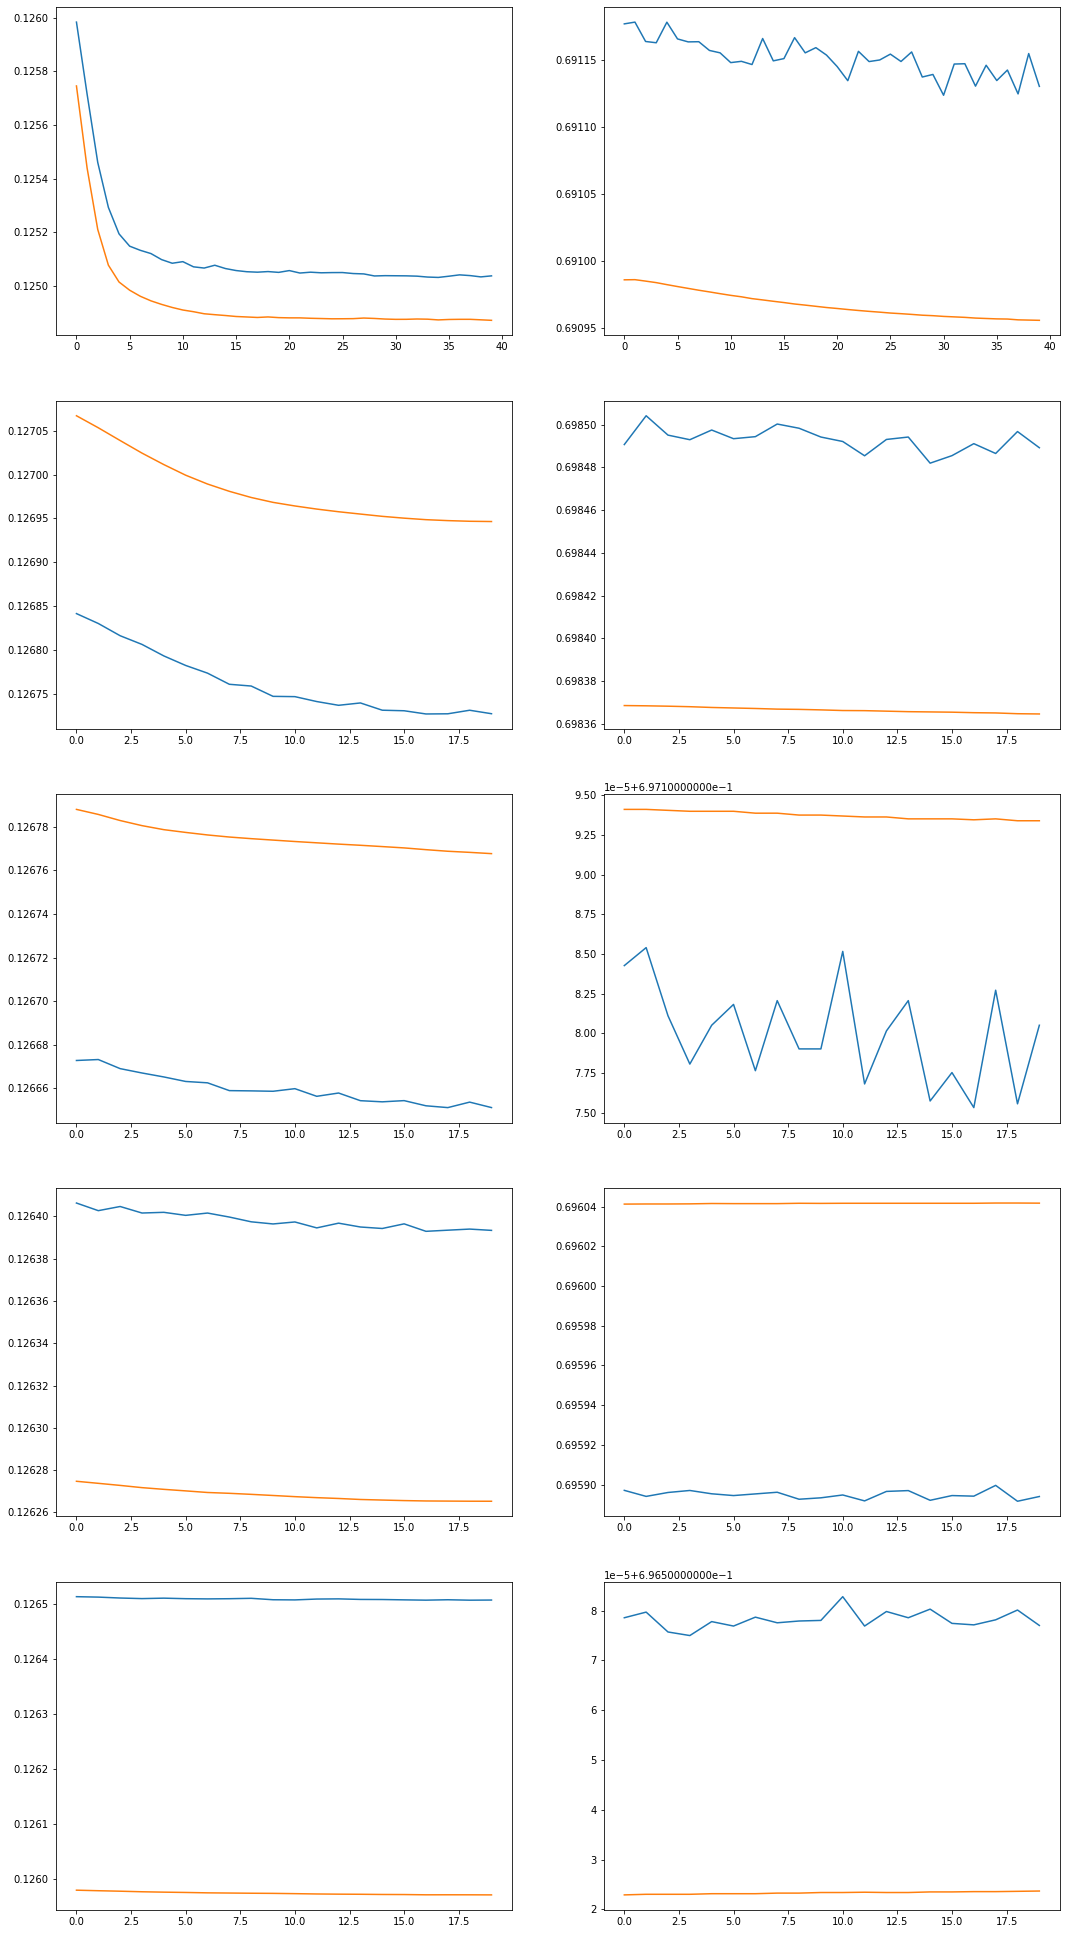

In [39]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

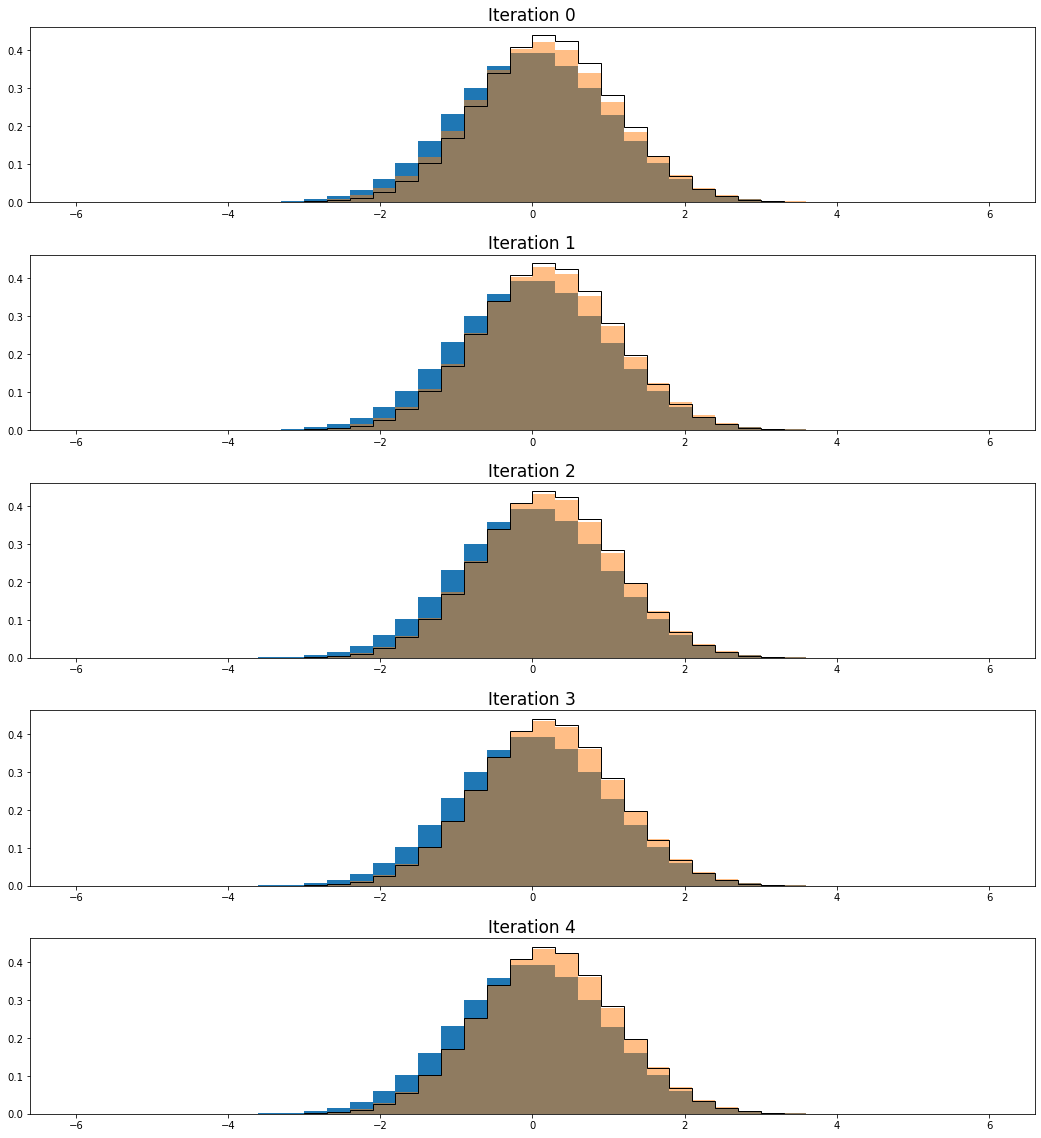

In [40]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [41]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

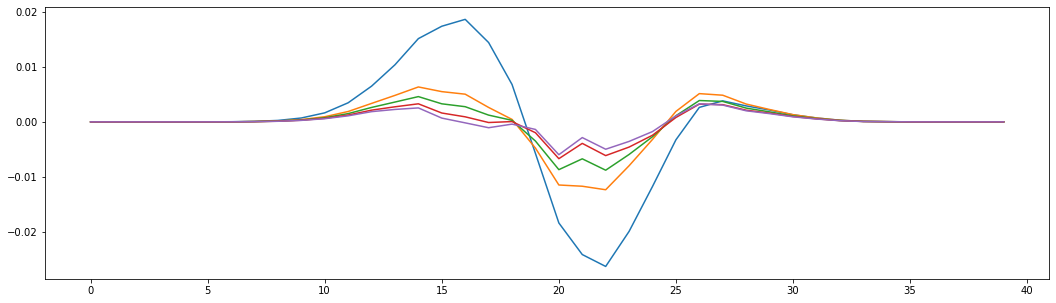

In [42]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

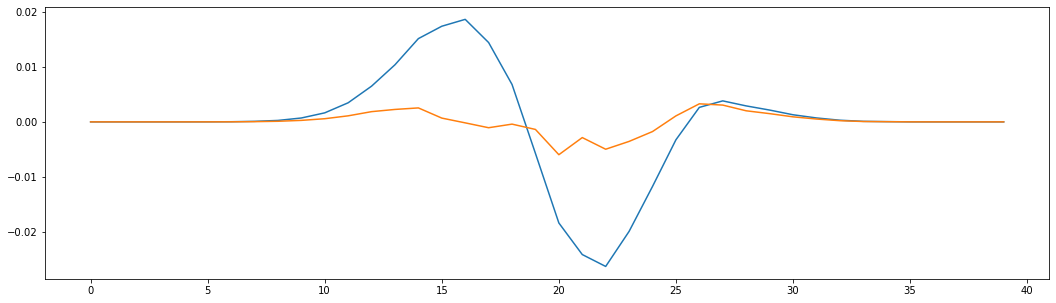

In [43]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

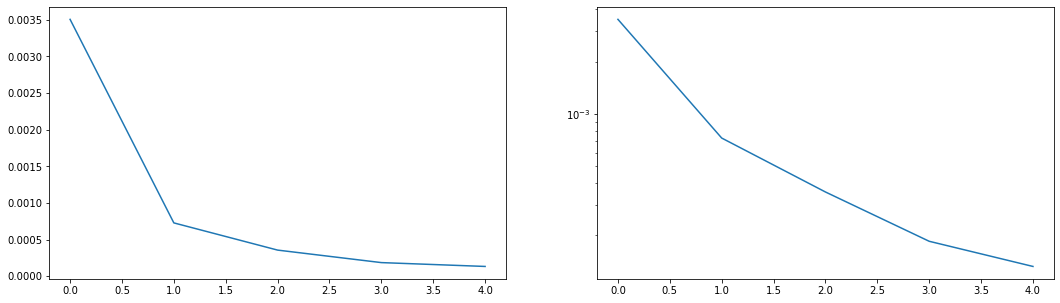

In [44]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

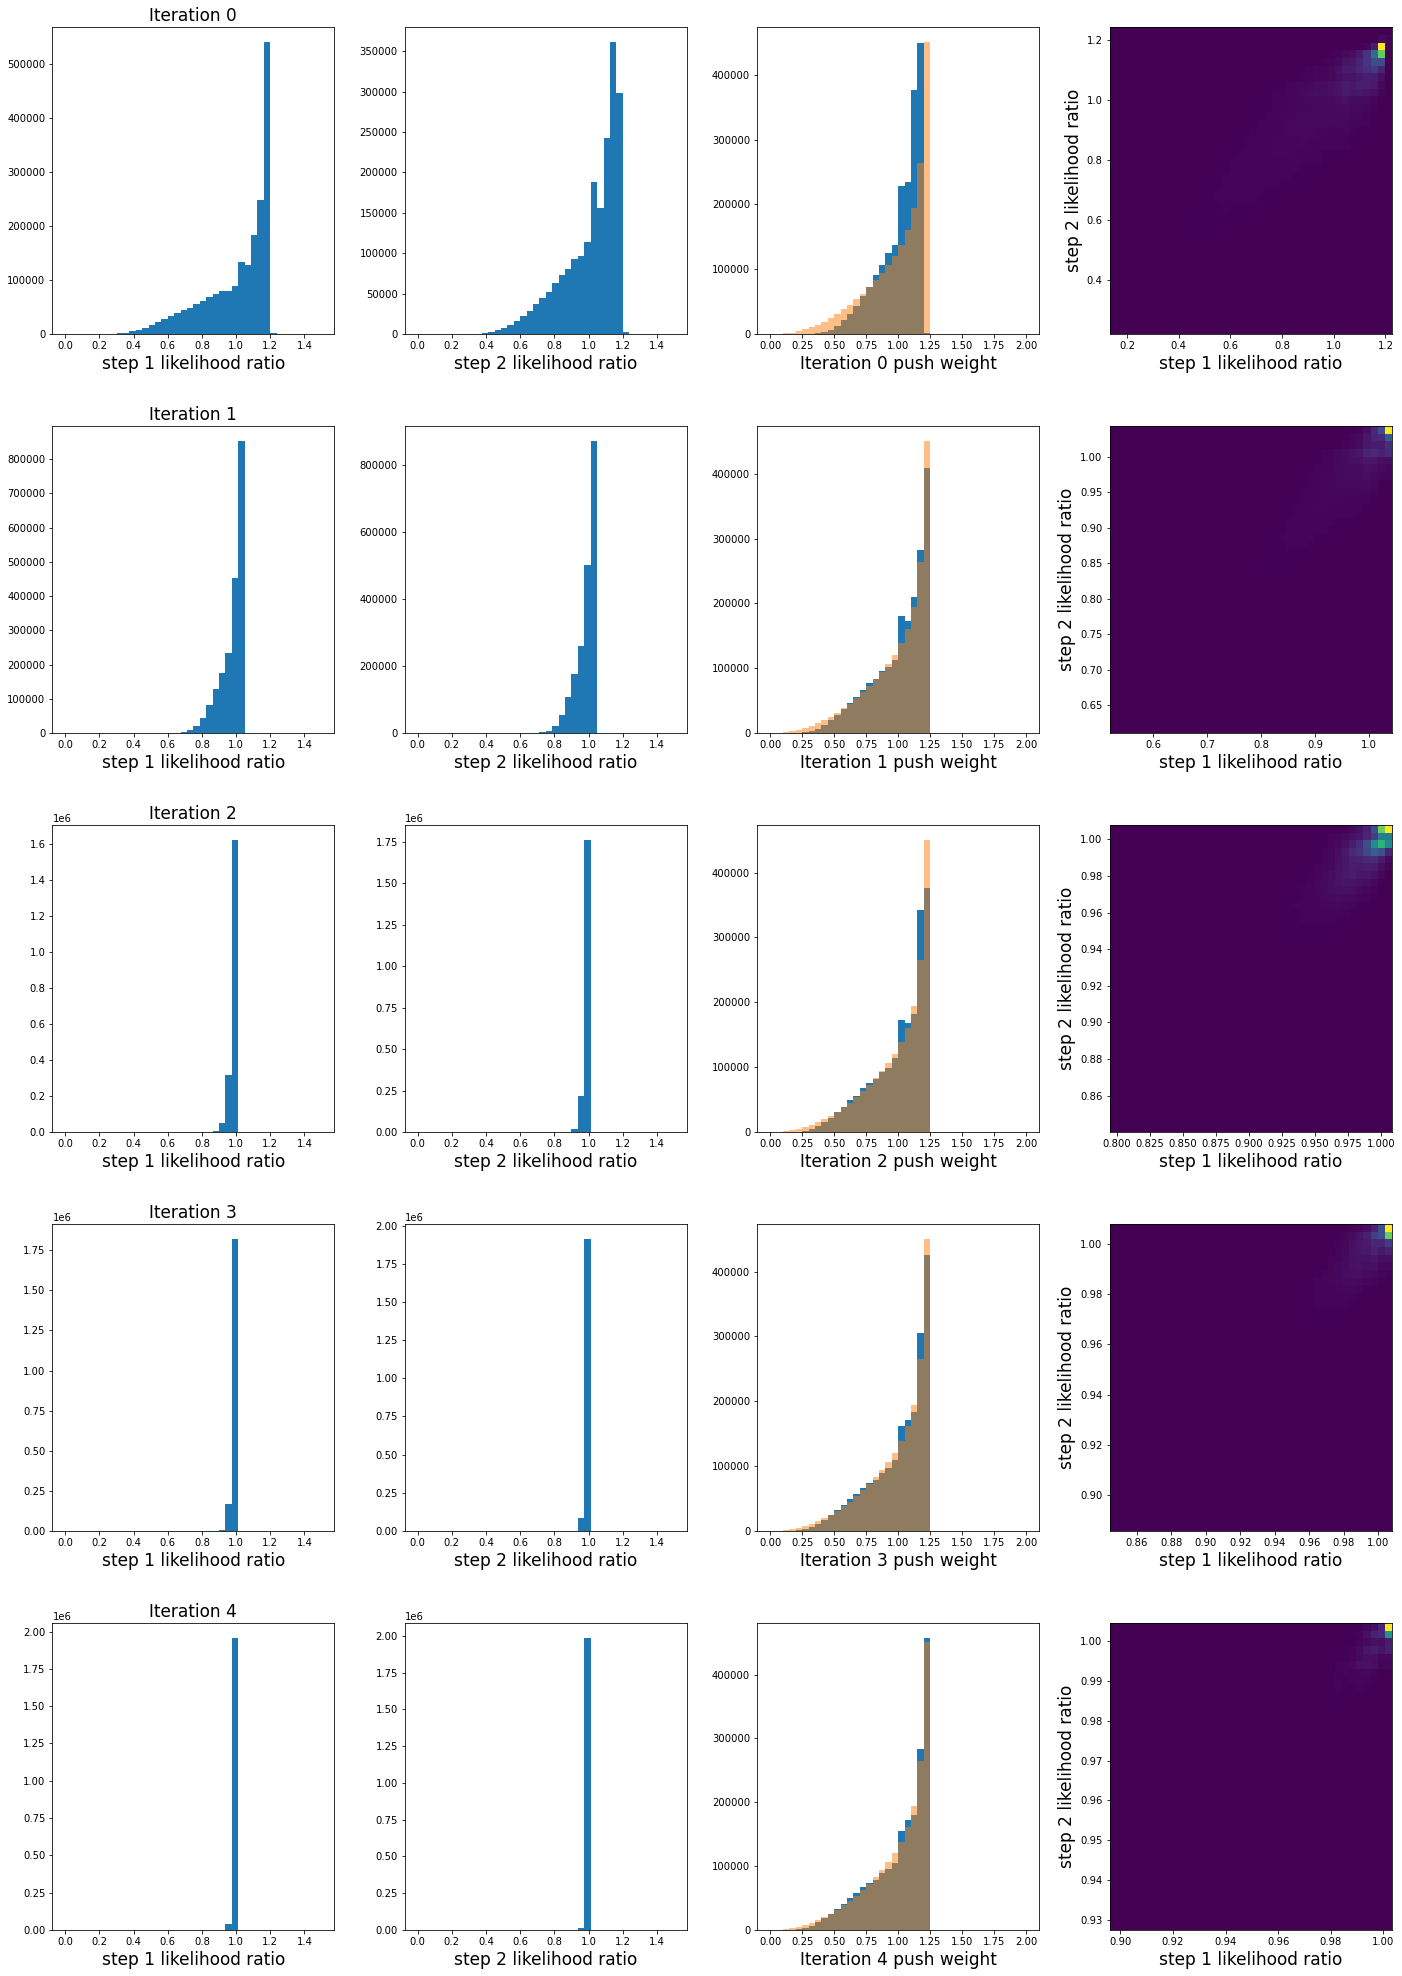

In [45]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

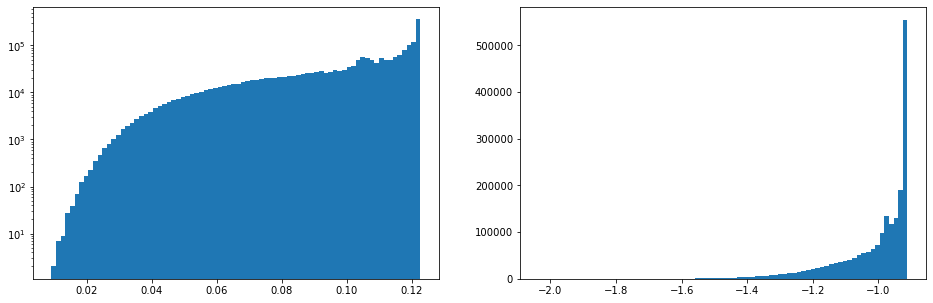

In [46]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

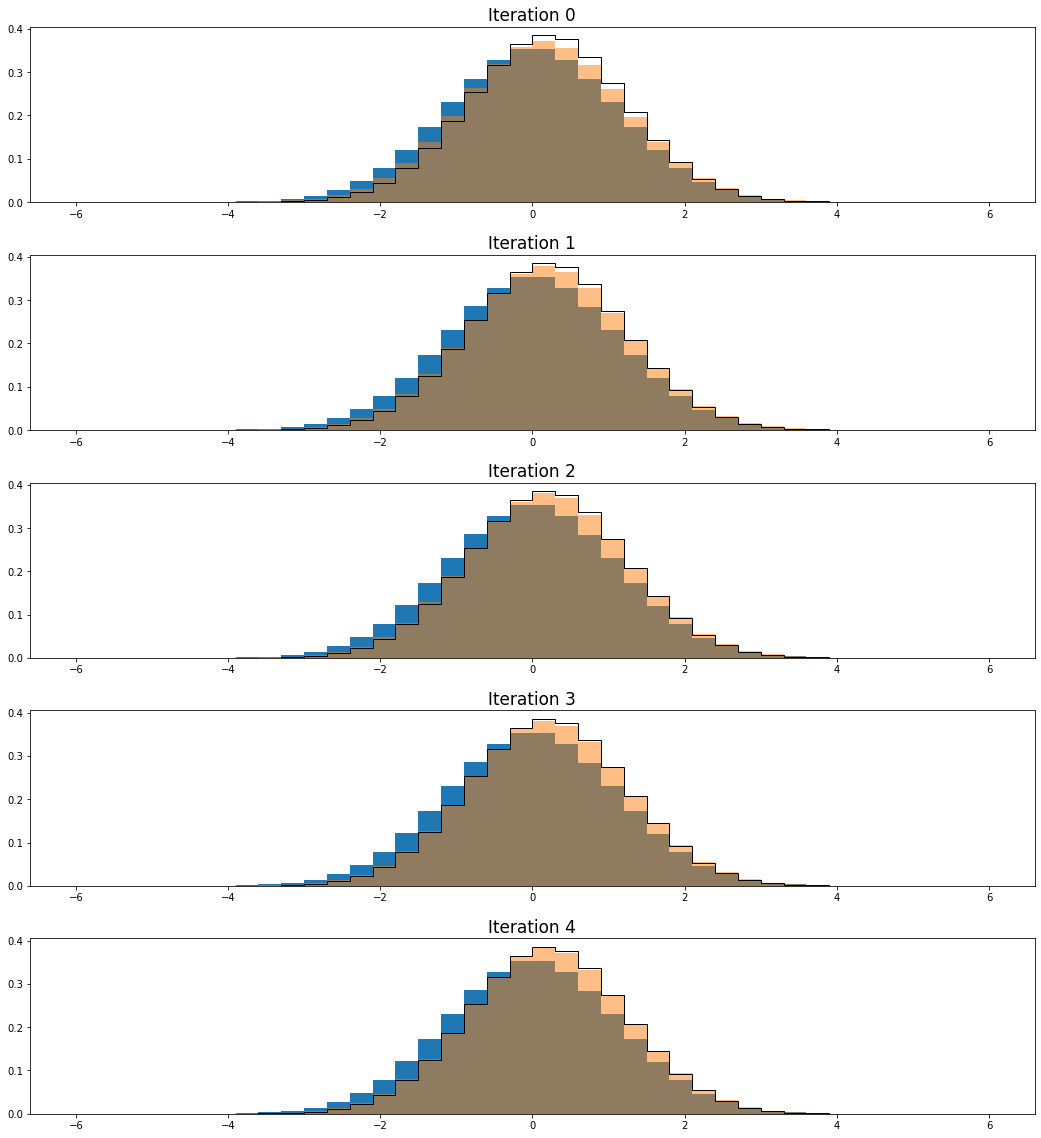

In [47]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [48]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

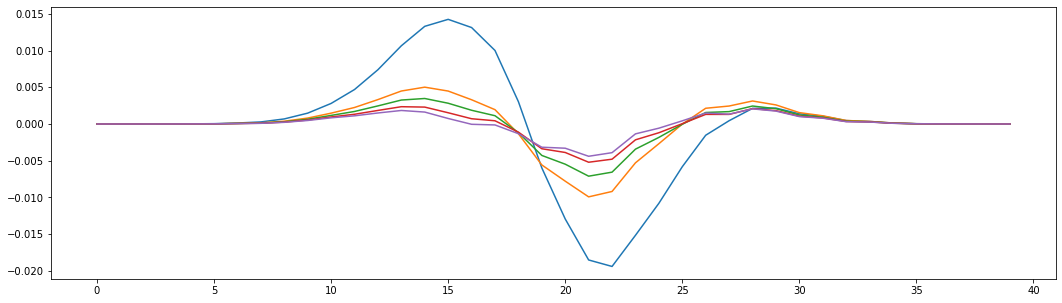

In [49]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

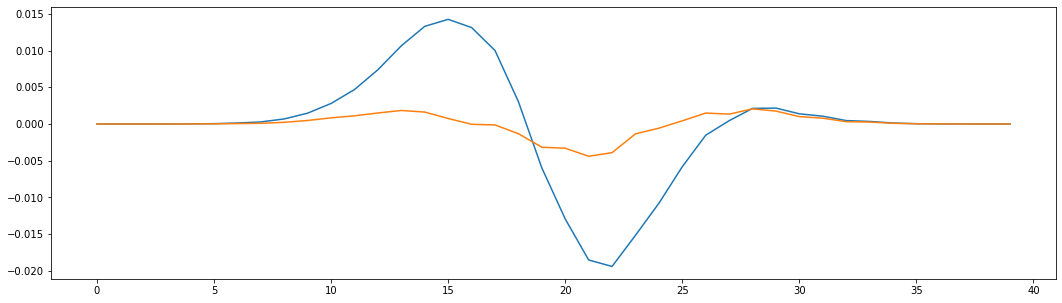

In [50]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

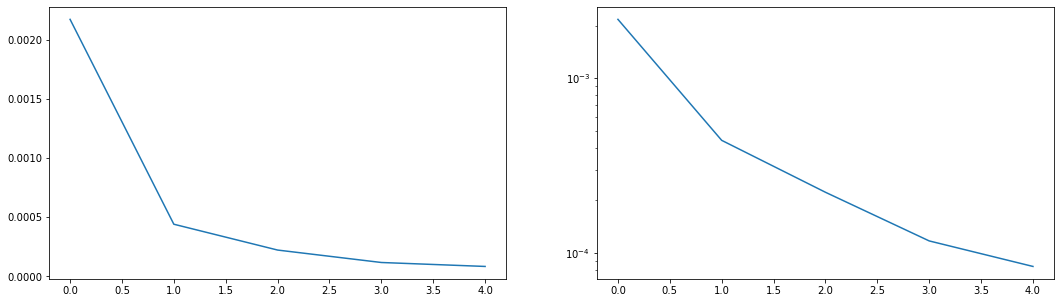

In [51]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [52]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.005  rms 0.192      step 2 mean  1.014  rms 0.162
  iter  1 : step 1 mean  0.980  rms 0.067      step 2 mean  0.988  rms 0.057
  iter  2 : step 1 mean  0.988  rms 0.019      step 2 mean  0.992  rms 0.015
  iter  3 : step 1 mean  0.995  rms 0.013      step 2 mean  0.998  rms 0.010
  iter  4 : step 1 mean  0.998  rms 0.008      step 2 mean  1.000  rms 0.006


<function matplotlib.pyplot.show(close=None, block=None)>

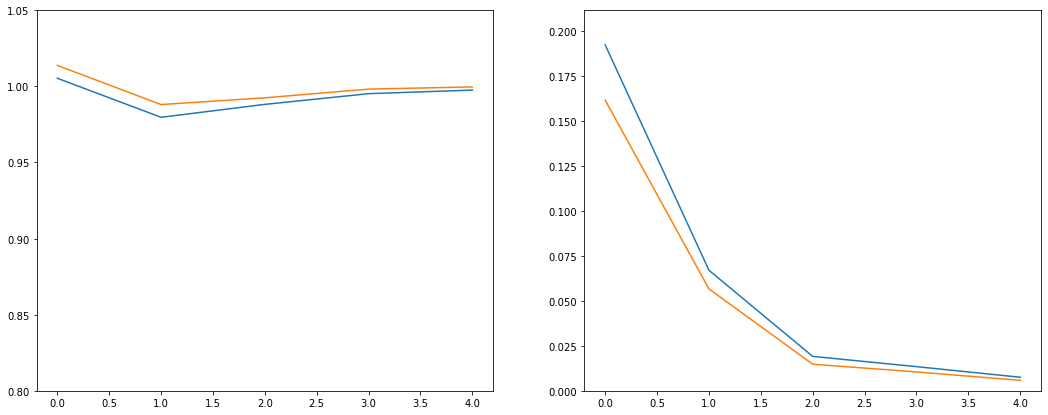

In [53]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

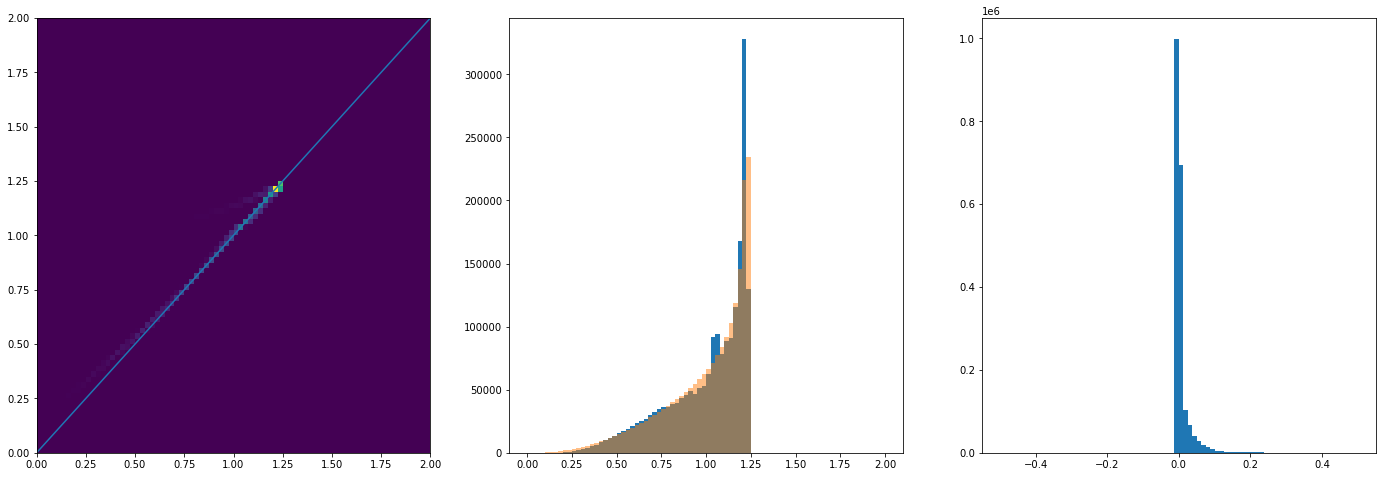

In [54]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [55]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.02761


